In [4]:
import mysql.connector as mysql
from mysql.connector.pooling import MySQLConnectionPool
import pandas as pd
import numpy as np
import json
from dataclasses import dataclass, field
from pathlib import Path
from typing import Any, Union, Optional
from pprint import pprint
import matplotlib.pyplot as plt

In [5]:
@dataclass
class db_conf():
    user: str
    password: str
    database: Optional[str] = None
    host: str = '127.0.0.1'
    port: int = 3306 
    
    def to_dict(self)->Optional[dict]:
        if all([self.user, self.password]):
            dict_conf = dict(
                user=self.user, host=self.host, password=self.password, 
                database=self.database, port=self.port
            )
            return dict_conf
        else:
            return None
    
    def to_json(self)->Optional[str]:
        db_dict = self.to_dict()
        if db_dict is None:
            return db_dict
        else:
            return json.dumps(db_dict)
    
    def write_conf(self, path:str)->None:
        name = 'db_conf.json'
        path = Path(path)
        json_file = self.to_json()
        
        if json_file is None:
            return json_file
        
        elif path.exists():
            with open(path / name, 'w') as file:
                file.write(json_file)
                return None
        else:
            raise FileExistsError
   
    @classmethod
    def load_conf(cls, path:str)->dict:
        
        path = Path(path)
        if path.exists():
            with open(path, 'r') as file:
                file = file.read()
                file_dict = json.loads(file)
            return file_dict
        else:
            raise FileExistsError
        
        
        
    def __dict__(self)->dict:
        return self.to_dict()
    
    def __call__(self, *args: Any, **kwarg: Any) -> Any:
        return self.to_dict()
    
    def __len__(self)->int:
        try:
            length = len(self.to_dict())
        except:
            length = 0
        return length
    
    def __getitem__(self, item:int)->Union[str,int]:
        try:
            item = list(self.to_dict().values())[item]
        except:
            item = 0
        return item 
            
    
    def __name__(self):
        host = self.host
        if str(host) == '127.0.0.1':
            host = 'localhost'
        elif not host:
            return 'Empty'
        return f'{self.user}@{host}'

In [6]:
conf = db_conf.load_conf('/Users/domel/Downloads/db_conf.json')

try:
    connector = mysql.connect(**conf)
except Exception as e:
    print('Connection Failed')
    raise print(e)

cursor = connector.cursor()

In [7]:
cursor.execute('USE LittleLemonDB')
cursor.execute('SHOW TABLES')

for n, results in  enumerate(cursor, 1):
    print(f'{n}): {results[0]}') 

1): Bookings
2): CustomerDetails
3): Menu
4): MenuItems
5): OrderDeliveryStatuses
6): Orders
7): ordersview
8): StaffInformation


In [8]:
query = """
    SELECT
        c.CustomerName,
        o.TotalCost,
        c.ContactDetails
    FROM
        Orders AS o
        JOIN CustomerDetails AS c ON o.CustomerID = c.CustomerID
    WHERE
        TotalCost > 60;
 """
 
cursor.execute(query)
results = cursor.fetchall()
columns = cursor.column_names

df = pd.DataFrame(results, columns=columns)

In [9]:
df_info = pd.concat([
        df[['CustomerName', 'TotalCost']],
        df['ContactDetails'].str.split(',', expand=True).rename({0:'Number', 1:'Email',2:'Address', 3:'Zip-Code'}, axis=1)], 
            axis=1)
df_info['Address'] = df_info['Address'].str.replace('\n', ' ')
df_info = df_info.rename_axis('Index', axis=0)
df_info.head(10)


,CustomerName,TotalCost,Number,Email,Address,Zip-Code
Index,,,,,,
0,Olivia Thompson,133,3149472479,bartonjack@example.net,95842 Hunt Springs Jenniferport,CO 05246
1,Michael Bennett,206,(435)208-9051,lauren53@example.com,17672 Brent Plaza Russellchester,GU 54234
2,Kathleen Klein,220,+1-624-406-6854x70962,jamesgarcia@example.net,6842 Manning Manors Apt. 978 North Paulburgh,CA 34188
3,Joseph Allison,159,919.892.9768x2690,obowers@example.org,999 Kirby Avenue Apt. 214 South Darren,DC 52870
4,William Wang,257,289.985.0977x531,hoovervirginia@example.net,07593 Anderson Ville Apt. 218 Oscarmouth,IL 06942
5,Brett Miller,214,(822)553-9624,brianhall@example.net,011 Adam Crossing New Jeremy,IN 14222
6,Angel Butler,208,+1-408-879-8305x056,tylerparks@example.org,92140 Christopher Extension Suite 173 New Sam...,MD 83622
7,Leah Bartlett,140,+1-943-289-1428,smithmichael@example.net,5626 Guzman Stravenue Suite 955 Rogerstown,NY 21057
8,Matthew Carrillo,159,551-901-4216x955,vking@example.com,46678 Cruz Union Lake Michellefurt,IL 41802


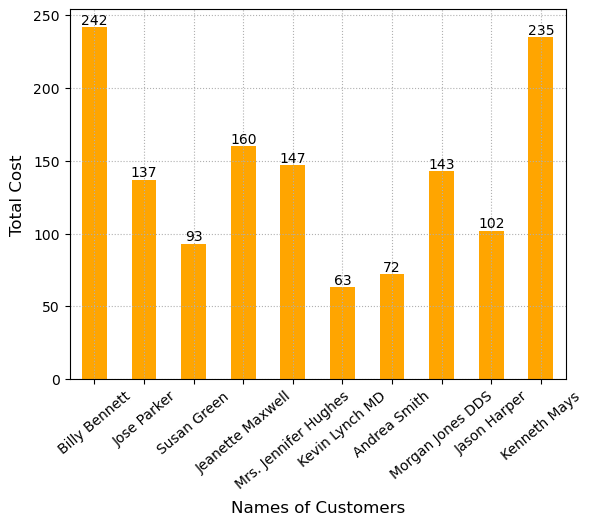

In [62]:
ax = df_info.groupby('CustomerName').sum().sample(10,random_state=34).plot.bar(legend=False, 
                                                                               color='orange')
ax.bar_label(ax.containers[0])
plt.xticks(ax.get_xticks(), rotation=40)
plt.xlabel('Names of Customers', labelpad=6, fontdict=dict(size=12))
plt.ylabel('Total Cost', labelpad=6, fontdict=dict(size=12))
plt.grid(ls=':')
plt.show()

In [42]:
['orange' if i % 2 == 0 else 'royalblue' for i in range(10)]

['orange',
 'royalblue',
 'orange',
 'royalblue',
 'orange',
 'royalblue',
 'orange',
 'royalblue',
 'orange',
 'royalblue']

In [8]:
cursor.close()
if connector.is_connected():
   connector.close() 